<a href="https://colab.research.google.com/github/mamirandamorante/SVHN/blob/main/Image_Classifier_using_SVHN_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project
## Image classifier for the SVHN dataset

Image classifier for the SVHN dataset
In this notebook, I create a neural network that classifies real-world images digits. I will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all. SVHN is obtained from house numbers in Google Street View images.

Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [ ]:
import tensorflow as tf
import random
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D,BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Load the dataset from your Drive folder

train = loadmat('/content/gdrive/MyDrive/path/to/train_32x32.mat')
test = loadmat('/content/gdrive/MyDrive/path/to/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel.
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [ ]:
#Extract the training and testing images and labels
X_train = train['X']
y_train = train['y']
X_test = test['X']
y_test = test['y']

print("Training Set", X_train.shape, y_train.shape)
print("Testing Set", X_test.shape, y_test.shape)

Training Set (32, 32, 3, 73257) (73257, 1)
Testing Set (32, 32, 3, 26032) (26032, 1)


In [ ]:
# Calculate the total number of images
num_images = X_train.shape[3] + X_test.shape[3]
print("Total Number of Images in the dataset:", num_images)

Total Number of Images in the dataset: 99289


In [ ]:
#Normalize the train and test images

X_train = X_train.astype('float64')
X_test = X_test.astype('float64')

y_train = y_train.astype('int64')
y_test = y_test.astype('int64')

X_train = X_train / 255.0
X_test = X_test / 255.0

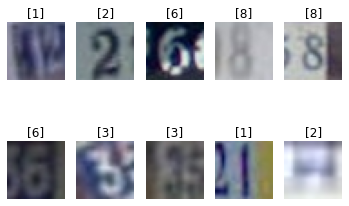

In [ ]:
# Plot 10 training set images and its labels
for i in range(10):
    elde = random.randint(0,1000)
    plt.subplot(2,5,i+1)
    plt.title(str(y_train[elde]), fontsize=12) 
    plt.imshow(X_train[:,:,:,elde]) 
    plt.axis("off") 
plt.show()

In [ ]:
#Convert trainint and test image sets from RGB to grayscale
X_train = np.average(X_train,axis = 2)
X_test = np.average(X_test,axis = 2)
print("Training Set", X_train.shape, y_train.shape)
print("Testing Set", X_test.shape, y_test.shape)

Training Set (32, 32, 73257) (73257, 1)
Testing Set (32, 32, 26032) (26032, 1)


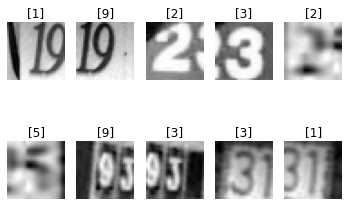

In [ ]:
# Plot 10 training set images and its labels
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(str(y_train[i]), fontsize=12) 
    plt.imshow(X_train[:,:,i], cmap=plt.get_cmap('gray'))
    plt.axis("off") 
plt.show()

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API using only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* Print out the model summary (using the summary() method)
* Compile and train the model, making use of both training and validation sets during the training run. 
* Use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [ ]:
X_train_mlp = np.moveaxis(X_train, -1, 0)
X_test_mlp = np.moveaxis(X_test, -1, 0)
X_train_mlp =X_train_mlp[..., np.newaxis]
X_test_mlp = X_test_mlp[..., np.newaxis]
print("Training Set", X_train_mlp.shape, y_train.shape)
print("Testing Set", X_test_mlp.shape, y_test.shape)

Training Set (73257, 32, 32, 1) (73257, 1)
Testing Set (26032, 32, 32, 1) (26032, 1)


In [ ]:
def get_model(input_shape):
    model = Sequential([
        Dense(128,activation='relu',input_shape=input_shape,name='Dense1'),
        Dense(128,activation='relu',name='Dense2'),
        Flatten(name='Flatten'),
        Dense(64,activation='relu',name='Dense3'),
        Dense(11,activation='softmax',name='Dense4')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model = get_model(X_train_mlp[0].shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense1 (Dense)               (None, 32, 32, 128)       256       
_________________________________________________________________
Dense2 (Dense)               (None, 32, 32, 128)       16512     
_________________________________________________________________
Flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
Dense3 (Dense)               (None, 64)                8388672   
_________________________________________________________________
Dense4 (Dense)               (None, 11)                715       
Total params: 8,406,155
Trainable params: 8,406,155
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Callbacks ModelCheckpoint and EarlyStopping
def get_checkpoint_best_only():
    checkpoint_best_only_path = 'checkpoints_best_only/checkpoint'
    checkpoint_best_only = ModelCheckpoint(filepath = checkpoint_best_only_path,
                                          save_weights_only=True,
                                          save_best_only=True,
                                          monitor = 'val_accuracy',
                                          verbose =1)
    return checkpoint_best_only

def get_early_stopping():
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=5)
    return callback

In [ ]:
checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()

In [ ]:
callbacks = [checkpoint_best_only,early_stopping]
history = model.fit(X_train_mlp, y_train, epochs=30, validation_split=0.15,callbacks=callbacks,verbose=1)

Epoch 1/30
1946/1946 [==============================] - 17s 8ms/step - loss: 2.2270 - accuracy: 0.1967 - val_loss: 1.6744 - val_accuracy: 0.4274

Epoch 00001: val_accuracy improved from -inf to 0.42743, saving model to checkpoints_best_only/checkpoint
Epoch 2/30
1946/1946 [==============================] - 16s 8ms/step - loss: 1.5601 - accuracy: 0.4735 - val_loss: 1.4309 - val_accuracy: 0.5246

Epoch 00002: val_accuracy improved from 0.42743 to 0.52462, saving model to checkpoints_best_only/checkpoint
Epoch 3/30
1946/1946 [==============================] - 16s 8ms/step - loss: 1.3757 - accuracy: 0.5425 - val_loss: 1.3472 - val_accuracy: 0.5598

Epoch 00003: val_accuracy improved from 0.52462 to 0.55983, saving model to checkpoints_best_only/checkpoint
Epoch 4/30
1946/1946 [==============================] - 16s 8ms/step - loss: 1.3185 - accuracy: 0.5700 - val_loss: 1.3032 - val_accuracy: 0.5747

Epoch 00004: val_accuracy improved from 0.55983 to 0.57467, saving model to checkpoints_best

In [ ]:
! ls -lh checkpoints_best_only

total 97M
-rw-r--r-- 1 root root   77 Dec 25 18:08 checkpoint
-rw-r--r-- 1 root root  97M Dec 25 18:08 checkpoint.data-00000-of-00001
-rw-r--r-- 1 root root 2.0K Dec 25 18:08 checkpoint.index


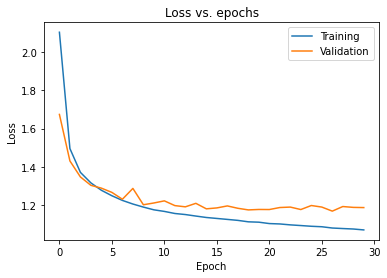

In [ ]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

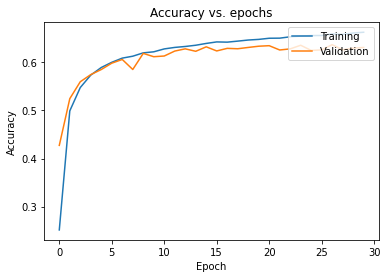

In [ ]:
# Plot the training and validation loss

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
def get_test_accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))
    print('loss: {los:0.3f}'.format(los=test_loss))

In [ ]:
#Compute and display the loss and accuracy of the trained model on the test set.
get_test_accuracy(model,X_test_mlp,y_test)

accuracy: 0.594
loss: 1.403


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API using the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* Compile and train the model, making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [ ]:
def get_checkpoint_best_only_cnn():
    checkpoint_best_only_path_cnn = 'checkpoints_best_only_cnn/checkpoint'
    checkpoint_best_only_cnn = ModelCheckpoint(filepath = checkpoint_best_only_path_cnn,
                                          save_weights_only=True,
                                          save_best_only=True,
                                          monitor = 'val_accuracy',
                                          verbose =1)
    return checkpoint_best_only_cnn

def get_early_stopping_cnn():
    callback_cnn = tf.keras.callbacks.EarlyStopping(patience=8)
    return callback_cnn

In [ ]:
def get_model_cnn(input_shape):
    cnn_model = Sequential([
        Conv2D(filters=32, input_shape=(32, 32, 1), kernel_size=(3, 3), activation='relu', padding ='same', name='conv_1'),
        BatchNormalization(),
        Conv2D(filters=32, kernel_size=(3, 3), padding ='same', activation='relu', name='conv_2'),
        MaxPooling2D(pool_size=(2, 2), name='pool_1'), 
        Dropout(0.3), 
        Conv2D(filters=64, kernel_size=(3, 3), padding ='same', activation='relu', name='conv_3'),
        MaxPooling2D(pool_size=(2, 2), name='pool_2'),  
        Dropout(0.3),  
        Conv2D(filters=128, kernel_size=(3, 3), padding ='same', activation='relu', name='conv_4'),
        BatchNormalization(),
        Conv2D(filters=128, kernel_size=(3, 3), padding ='same', activation='relu', name='conv_5'),
        MaxPooling2D(pool_size=(2, 2), name='pool_3'),  
        Dropout(0.3),
        Flatten(name='flatten'),
        Dropout(0.4),  
        Dense(units=11, activation='softmax', name='dense_1')
    ])  
    optimizer = tf.keras.optimizers.Adam(lr=1e-3, amsgrad=True)
    cnn_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return cnn_model

In [ ]:
cnn_model = get_model_cnn(X_train_mlp[0].shape)
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv_2 (Conv2D)              (None, 32, 32, 32)        9248      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 16, 16, 64)        18496     
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 8, 8, 64)         

In [ ]:
checkpoint_best_only_cnn = get_checkpoint_best_only_cnn()
early_stopping_cnn = get_early_stopping_cnn()

In [ ]:
callbacks_cnn=[checkpoint_best_only_cnn,early_stopping_cnn]
history = cnn_model.fit(X_train_mlp, y_train, epochs=30, batch_size = 128, validation_split=0.15,verbose=1, callbacks=callbacks_cnn)

Epoch 1/30
487/487 [==============================] - 8s 12ms/step - loss: 2.1724 - accuracy: 0.3206 - val_loss: 1.0924 - val_accuracy: 0.6369

Epoch 00001: val_accuracy improved from -inf to 0.63691, saving model to checkpoints_best_only_cnn/checkpoint
Epoch 2/30
487/487 [==============================] - 5s 11ms/step - loss: 0.5660 - accuracy: 0.8223 - val_loss: 0.4843 - val_accuracy: 0.8502

Epoch 00002: val_accuracy improved from 0.63691 to 0.85021, saving model to checkpoints_best_only_cnn/checkpoint
Epoch 3/30
487/487 [==============================] - 5s 11ms/step - loss: 0.4490 - accuracy: 0.8612 - val_loss: 0.3179 - val_accuracy: 0.9046

Epoch 00003: val_accuracy improved from 0.85021 to 0.90463, saving model to checkpoints_best_only_cnn/checkpoint
Epoch 4/30
487/487 [==============================] - 5s 11ms/step - loss: 0.3893 - accuracy: 0.8813 - val_loss: 0.3023 - val_accuracy: 0.9118

Epoch 00004: val_accuracy improved from 0.90463 to 0.91182, saving model to checkpoints_

In [ ]:
! ls -lh checkpoints_best_only_cnn/checkpoint

-rw-r--r-- 1 root root 77 Dec 25 18:11 checkpoints_best_only_cnn/checkpoint


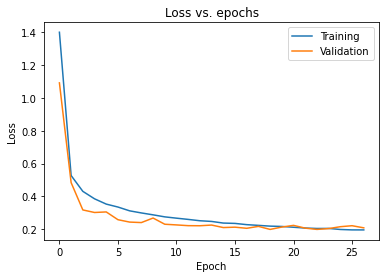

In [ ]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

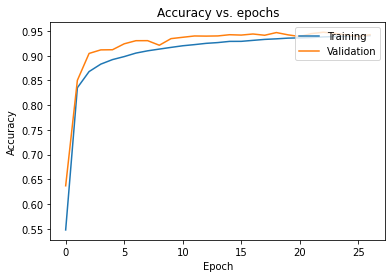

In [ ]:
# Plot the training and validation loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
#Compute and display the loss and accuracy of the trained model on the test set.
get_test_accuracy(cnn_model,X_test_mlp,y_test)


accuracy: 0.947
loss: 0.202


## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [ ]:
! ls -lh checkpoints_best_only

total 97M
-rw-r--r-- 1 root root   77 Dec 25 18:08 checkpoint
-rw-r--r-- 1 root root  97M Dec 25 18:08 checkpoint.data-00000-of-00001
-rw-r--r-- 1 root root 2.0K Dec 25 18:08 checkpoint.index


In [ ]:
#Load the best weights for the MLP and CNN models that you saved during the training run
model.load_weights('checkpoints_best_only/checkpoint')
cnn_model.load_weights('checkpoints_best_only_cnn/checkpoint')


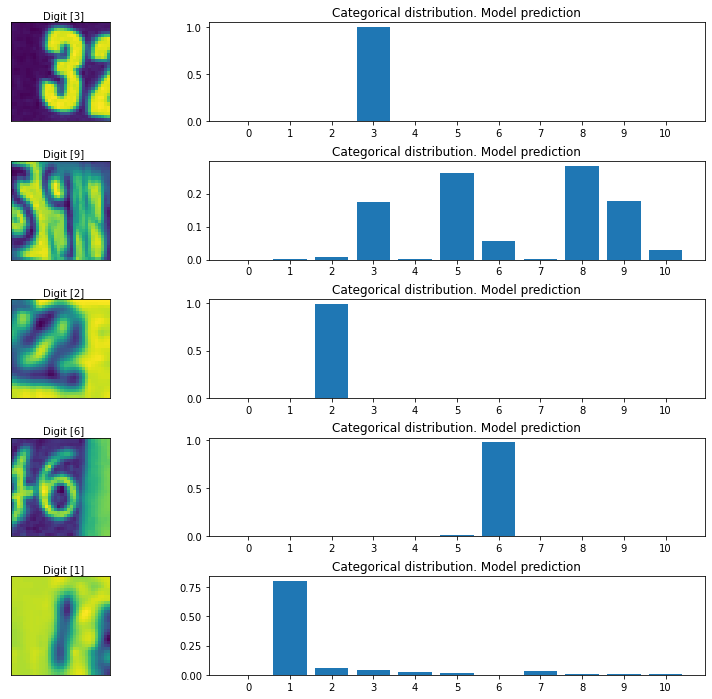

In [ ]:
#Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
num_test_images = X_test_mlp.shape[0]

random_inx = np.random.choice(num_test_images, 5)
random_test_images = X_test_mlp[random_inx, ...]
random_test_labels = y_test[random_inx, ...]

predictions = model.predict(random_test_images)

fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(len(prediction)),prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title("Categorical distribution. Model prediction")
    
plt.show()

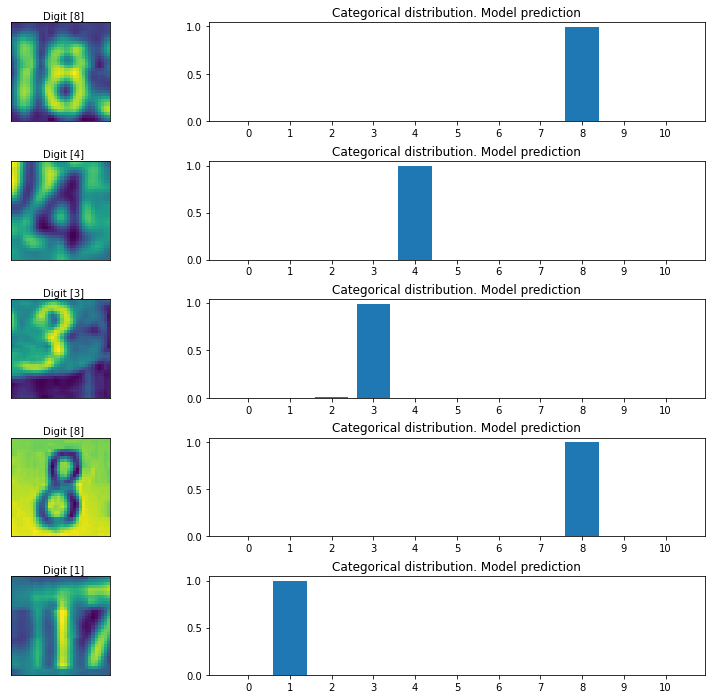

In [ ]:
num_test_images = X_test_mlp.shape[0]

random_inx = np.random.choice(num_test_images, 5)
random_test_images = X_test_mlp[random_inx, ...]
random_test_labels = y_test[random_inx, ...]

predictions = cnn_model.predict(random_test_images)

fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title("Categorical distribution. Model prediction")
    
plt.show()

**Clear Directories**

In [ ]:
! rm -r checkpoints_best_only

In [ ]:
! rm -r checkpoints_best_only_cnn